In [1]:
import sri_tabi_problem as sri  # TODO rename to sirlo

import pyro
import torch
from pyro.infer.autoguide import AutoMultivariateNormal
import pyro.distributions as dist
import matplotlib.pyplot as plt
from enum import Enum
from chirho.dynamical.ops import State, Trajectory
from collections import OrderedDict
from typing import (
    Optional,
    Union,
)
import numpy as np
import old_ep_demo_scratch as stor
from sklearn.neighbors import KernelDensity

import chirho.contrib.compexp as ep  # TODO rename to expectation_programming (?)

pyro.settings.set(module_local_params=True)

PT = torch.nn.Parameter
TT = torch.Tensor
tt = torch.tensor
UPTT = Union[PT, TT]

assert sri.LOCKDOWN_TYPE == sri.LockdownType.NONCONT_STATE

In [9]:
# Define some default values for parameters.

# Decision (lockdown) parameters.
DEFAULT_DPARAMS = DDP = OrderedDict(
    # When the infected proportion of the population exceeds this value, a lockdown is triggered.
    lockdown_trigger=torch.nn.Parameter(tt(0.1)),
    # When the recovered proportion of the population exceeds this value, the lockdown is lifted.
    lockdown_lift_trigger=torch.nn.Parameter(tt(0.32)),
    # The strength of the lockdown.
    lockdown_strength=torch.nn.Parameter(tt(0.7))
)

# Latent paremeters.
DEFAULT_STOCHASTICS = DST = OrderedDict(
    # The infection transmission rate.
    beta=tt(10.2),
    # The infection recovery rate.
    gamma=tt(2.0),
    # The capacity of the healthcare system as a proportion of the population.
    capacity=tt(0.01),
    # The rate at which infected individuals require hospitalization.
    hospitalization_rate=tt(0.05)
)

# Initial conditions.
DEFAULT_INIT_STATE = DIS = State(
    # Proportion of the population susceptible to a disease.
    S=tt(0.99),
    # Proportion of the population infected with a disease.
    I=tt(0.01),
    # Proportion of the population recovered from a disease.
    R=tt(0.0),
    # Strength of active lockdown.
    l=tt(0.0),
    # Integral over strength of past lockdowns. This is a proxy measure of the social and economic
    # costs incurred from a lockdown.
    L=tt(0.0),
    # Integral of the number of individuals requiring hospitalization that could not receive it.
    O=tt(0.0)
)

# Timespan of interest.
DEFAULT_TIMES = DT = torch.linspace(0., 5., 100)

# Utility function allowing copies that ensure default parameters are unaffected.
def copy_odict(odict: OrderedDict[str, TT]) -> OrderedDict[str, TT]:
    return OrderedDict((k, TT(v.item())) for k, v in odict.items())

def copy_podict(odict: OrderedDict[str, PT]) -> OrderedDict[str, PT]:
    return OrderedDict((k, PT(tt(v.item()))) for k, v in odict.items())

In [3]:
# A prior defined only for parameters affecting healthcare capacity overruns.
def _pyro_prior_over_healthcare_params():
    capacity = pyro.sample(
        "capacity", dist.Normal(DST['capacity'], 0.003))
    hospitalization_rate = pyro.sample(
        "hospitalization_rate", dist.Normal(DST['hospitalization_rate'], 0.015))
    return OrderedDict(
        capacity=capacity,
        hospitalization_rate=hospitalization_rate
    )

# A prior defined only for parameters affecting the vanilla SIR model.
def _pyro_prior_over_sir_params():
    beta = pyro.sample(
        "beta", dist.Normal(DST['beta'], 1.0))
    gamma = pyro.sample(
        "gamma", dist.Normal(DST['gamma'], .2))
    return OrderedDict(
        beta=beta,
        gamma=gamma
    )

# A prior over all four stochastic variables.
def pyro_prior_full():
    healthcare_params = _pyro_prior_over_healthcare_params()
    sir_params = _pyro_prior_over_sir_params()
    return OrderedDict(**healthcare_params, **sir_params)

# A prior only over the two SIR parameters, leaving the healthcare parameters constant.
def pyro_prior_sir():
    return copy_odict(DST) | _pyro_prior_over_sir_params()

## Modeling Lockdowns and Burden on Healthcare System

In the **top panel**, we see the trajectory of a standard SIR model affected by a lockdown. The infected proportion rises until the lockdown is triggered, at which time the curve flattens. In this case, this severe lockdown is lifted prematurely, and the infected curve rises to a proportion resulting in a healthcare criss.
The **middle panel** zooms in on this curve and shows the aggregate overrun of the healthcare system.
The **bottom panel** shows the strength of the lockdown over time and the aggregate cost of that lockdown.

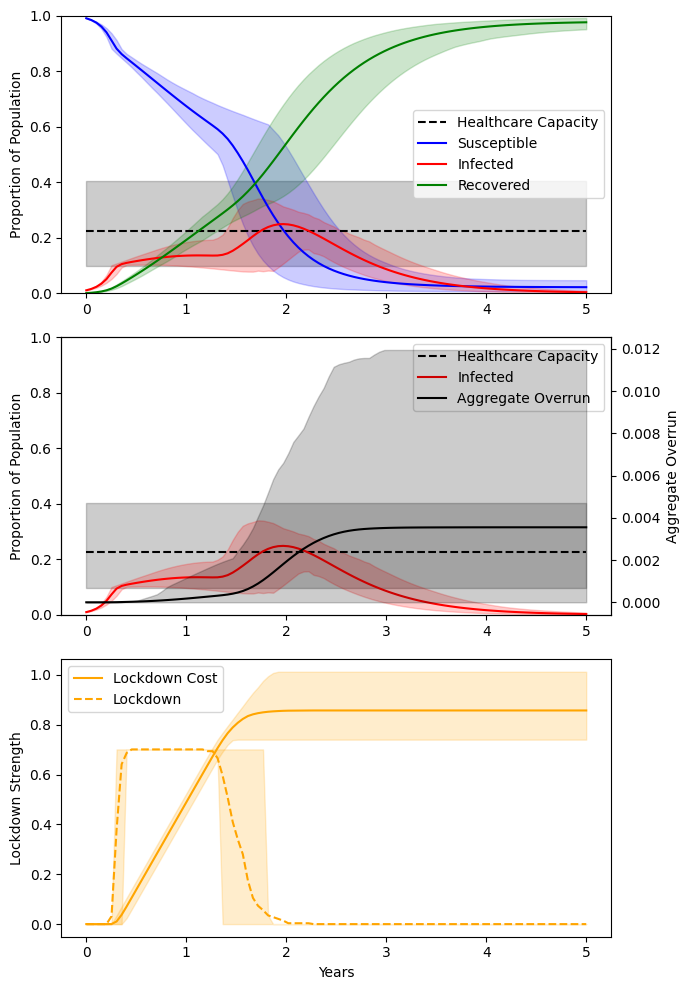

In [4]:
sri.plot_basic(
    dparams=DDP,
    stochastics=[pyro_prior_full() for _ in range(200)],
    init_state=DIS,
    timespan=DT,
    ci=0.9
)

## Minimizing Lockdown Severity while Avoiding Healthcare System Burden

Overburdening the healthcare system is clearly something to avoid, but lockdowns induce steep social and economic costs. Can policymakers avoid overburdening the hospital system while minimizing the length and severity of the lockdown? As a first step, we define functionals that measure the expected costs with respect to the uncertainty induced by a distribution over the stochastic parameters.

In [5]:
def get_costs(dparams: ep.typedecs.KWTypeNNParams):

    def lockdown_cost_(stochastics: ep.typedecs.KWType) -> torch.Tensor:
        traj = sri.get_traj(dparams, stochastics, timespan=DT, init_state=DIS)
        # Return the aggregate cost of the lockdown at the end of the simulation.
        return traj.L[-1]

    def healthcare_burden_(stochastics: ep.typedecs.KWType) -> torch.Tensor:
        traj = sri.get_traj(dparams, stochastics, timespan=DT, init_state=DIS)
        # Return the aggregate burden on the healthcare system at the end of the simulation.
        return traj.O[-1]

    return lockdown_cost_, healthcare_burden_

In [10]:
# Cost functions of interest.
optimizeable_decision_parameters = copy_podict(DDP)
lockdown_cost, healthcare_burden = get_costs(optimizeable_decision_parameters)

# Functionals of these costs, defined as expectations from the `expectation_programming` package.
expected_lockdown_cost = ep.E(f=lockdown_cost, name='elc')
expected_healthcare_burden = ep.E(f=healthcare_burden, name='ehb')

### Combined Cost
As a first step, we'll combine these into a single cost function. The `expectation_programming` package allows us to use standard python syntax to do so, except that constant factors must be wrapped in `ep.Constant` objects. The scaling here is simply to put the two costs on compareable scales.

In [11]:
expected_combined_cost = ep.Constant(tt(2e2)) * expected_healthcare_burden + expected_lockdown_cost

### Estimating Expectations
To estimate an expectation, we must employ one of the expectation handlers provided in the `expectation_programming` package. These handlers define how an expectation will be estimated. For example, the monte carlo handler below simply samples from `pyro_prior_full`, pushes those samples through the cost functions, and then averages the results.

In [12]:
with ep.MonteCarloExpectationHandler(num_samples=100):
    print("Expected Combined Cost:", expected_combined_cost(pyro_prior_full))

Expected Combined Cost: tensor(1.6945, grad_fn=<AddBackward0>)


### Optimizing Lockdown Policy with SGD
We can also take gradients of these expectations, and then utilize those gradient estimates in an SGD algorithm to optimize the lockdown parameters. The `ep.ComposedExpectation` cost is passed to a `DecisionOptimizer`, which then calls `ep.ComposedExpectation.grad` to get a new `ep.ComposedExpectation` defining the expected gradient of the original cost function with respect to the decision parameters. This gradient then features in components of the optimization loop, and is estimated just like any other `ep.ComposedExpectation`.

In [20]:
class DecisionOptimizer:
    def __init__(
            self,
            dparams: ep.typedecs.KWTypeNNParams,
            model: ep.typedecs.ModelType,
            cost: ep.ComposedExpectation,
            expectation_handler: ep.ExpectationHandler,
            lr: float
    ):
        self.dparams = dparams
        self._flat_dparams = ep.utils.flatten_dparams(self.dparams)
        self.model = model
        # ep.ComposedExpectation objects can be auto-differentiated.
        self.cost_grad = cost.grad(self._flat_dparams)
        self.expectation_handler = expectation_handler

        self.optim = torch.optim.SGD(list(self.dparams.values()), lr=lr)

    def estimate_grad(self):
        self.optim.zero_grad()
        for d in self.dparams.values():
            d.grad = None

        with self.expectation_handler:
            grad_estimate_: TT = self.cost_grad(self.model)

        return grad_estimate_

    def step_grad(self, grad_estimate_):

        grad_estimate_: ep.typedecs.KWType = ep.utils.unflatten_df_dparams(grad_estimate_, self.dparams)

        for k, dp in grad_estimate_.items():
            dp.grad = grad_estimate_[k]

        self.optim.step()

    def step(self):
        grad_estimate = self.estimate_grad()
        self.step_grad(grad_estimate)

In [21]:
combined_do = DecisionOptimizer(
    dparams=optimizeable_decision_parameters,
    model=pyro_prior_full,
    cost=expected_combined_cost,
    # For SGD, we just use a single sample per update.
    expectation_handler=ep.MonteCarloExpectationHandler(num_samples=1),
    lr=1e-1
)

lockdown_lift_vals = []
lockdown_trigger_vals = []
lockdown_strength_vals = []

for _ in range(1000):
    combined_do.step()

    lockdown_lift_vals.append(optimizeable_decision_parameters['lockdown_lift'].value)
    lockdown_trigger_vals.append(optimizeable_decision_parameters['lockdown_trigger'].value)
    lockdown_strength_vals.append(optimizeable_decision_parameters['lockdown_strength'].value)

TypeError: 'NoneType' object is not subscriptable